In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout



Length of descriptions = 8092
Length of vocabulary =  8763


In [66]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in os.listdir(directory):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features

In [67]:
#2048 feature vector
dataset_images = 'G:\CLProject\Flickr8k_Dataset\Flicker8k_Dataset'
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 334ms/step


1/1 [==============================] - 0s 447ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 327ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 334ms/step


1/1 [==============================] - 0s 335ms/step


1/1 [==============================] - 0s 354ms/step


1/1 [==============================] - 0s 346ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 353ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 357ms/step


In [68]:
features = load(open("features.p","rb"))

In [69]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [70]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [71]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [72]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

In [73]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [79]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 32, 256)      1939712     ['input_30[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_29[0][0]'] 

1/1 [==============================] - 1s 969ms/step



start man in red and white is riding bike on dirt road end


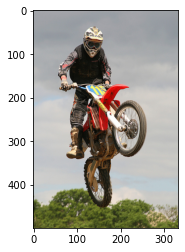

In [12]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse


# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']

img_path = r"C:\Users\bhado\CLProject\Flickr8kDataset\2902269566_419d9f1d8e.jpg"

def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)


